In [162]:
import matplotlib.pyplot as plt
# import seaborn as sns
import numpy as np 
import os
import pandas as pd
from scipy import stats
%matplotlib inline
%autosave 300
%load_ext autoreload
%autoreload 2
from sklearn.preprocessing import scale
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from pandas.tools.plotting import scatter_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_selection import chi2
from pandas.tools.plotting import scatter_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn import linear_model

plt.rcParams['figure.figsize'] = (8, 4)
# plt.rcParams['font.size'] = 16
# plt.rcParams['text.usetex'] = False
# plt.rcParams['axes.labelsize'] = plt.rcParams['font.size']
# plt.rcParams['axes.titlesize'] = 1.5*plt.rcParams['font.size']
# plt.rcParams['legend.fontsize'] = 16
# plt.rcParams["figure.facecolor"] = 'white'

Autosaving every 300 seconds
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [178]:
from sklearn.model_selection import KFold
num_splits = 10.0
kf = KFold(n_splits=int(num_splits))

In [3]:
df_train = pd.read_csv('/Users/tjiang/Desktop/Personal/Stats202/my_repo/Final_Project/data/training.csv', delimiter=',')
df_test = pd.read_csv('/Users/tjiang/Desktop/Personal/Stats202/my_repo/Final_Project/data/test.csv', delimiter=',')

In [4]:
df_train.head()

,query_id,url_id,query_length,is_homepage,sig1,sig2,sig3,sig4,sig5,sig6,sig7,sig8,relevance
0,4631,28624,2,1,0.09,0.15,1288,352,376,13,0.46,0.35,0
1,4631,28625,2,1,0.20,0.35,4662,337,666,28,0.43,0.27,1
2,4631,28626,2,1,0.36,0.49,1121,385,270,15,0.34,0.20,1
3,4631,28627,2,1,0.21,0.45,2925,478,640,14,0.44,0.33,1
4,4631,28628,2,1,0.25,0.42,1328,429,412,27,0.40,0.57,1


In [5]:
df_test.head()

,query_id,url_id,query_length,is_homepage,sig1,sig2,sig3,sig4,sig5,sig6,sig7,sig8
0,0,0,4,0,0.13,0.33,0,1,0,0,0.19,0.47
1,0,1,4,0,0.12,0.40,247,477,4,0,0.22,0.59
2,0,2,4,0,0.15,0.41,303,313,44,0,0.20,0.81
3,0,3,4,0,0.06,0.35,1035,415,130,0,0.35,0.77
4,0,51,4,0,0.18,0.33,2,0,0,0,0.21,0.63


## Begin by visual inspection of data

In [6]:
#Redraw to split predictor color
#Takes long time to run
# scatter_matrix(df_train, alpha=0.2, figsize=(40, 40), diagonal='hist')
pass

## Create new feature using query_id

In [7]:
'''ordered the data by query_id and url_id, but reset the value to 1 whenever the previous
observation of the url_id was more than one value away from the current observation 
or if it was a new query_id'''
df_train.sort_values(['query_id','url_id'], inplace=True)
query_num_list = []
num_queries_list = []
previous_url_id = 0
current_query_num = 0
for i in df_train['url_id']:
    if abs(previous_url_id-i) > 1:
        tally = current_query_num + 1
#         for j in xrange(tally):
#             num_queries_list.append(tally)
        current_query_num = 1
    else:
        current_query_num += 1
    query_num_list.append(current_query_num)
    previous_url_id = i
df_train['query_num'] = query_num_list
df_train['query_num'], _ = stats.boxcox(df_train['query_num']+1)

In [32]:
num_queries_list = []
prev_val = 0
tally = 0
for idx, val in enumerate(query_num_list):
    if prev_val < val:
        tally += 1
    elif prev_val == val:
        num_queries_list.append(1)
        tally = 1
    else:
        for j in xrange(tally):
            num_queries_list.append(tally)
        tally = 1
    prev_val = val
    
for j in xrange(tally):
    num_queries_list.append(tally)
print len(num_queries_list)

80046


## Modify existing features with transforms

In [91]:
df_train['query_length_tr'] = (df_train['query_length'] + 1).apply(np.log)
df_train['sig1_tr'] = df_train['sig1'].apply(np.sqrt)
df_train['sig3_tr'] = (df_train['sig3'] + 1).apply(np.log)
df_train['sig4_tr'] = (df_train['sig4'] + 1).apply(np.log)
df_train['sig5_tr'] = (df_train['sig5'] + 1).apply(np.log)
df_train['sig6_tr'], _ = stats.boxcox(df_train['sig6']+1)
df_train['num_queries'] = (pd.DataFrame(num_queries_list).apply(np.log))

In [77]:
df_train.head()

,query_id,url_id,query_length,is_homepage,sig1,sig2,sig3,sig4,sig5,sig6,...,sig8,relevance,query_num,query_length_tr,sig1_tr,sig3_tr,sig4_tr,sig5_tr,sig6_tr,num_queries
0,4631,28624,2,1,0.09,0.15,1288,352,376,13,...,0.35,0,0.700458,1.098612,0.300000,7.161622,5.866468,5.932245,0.985051,2.410142
1,4631,28625,2,1,0.20,0.35,4662,337,666,28,...,0.27,1,1.117053,1.098612,0.447214,8.447414,5.823046,6.502790,1.030866,2.410142
2,4631,28626,2,1,0.36,0.49,1121,385,270,15,...,0.20,1,1.415744,1.098612,0.600000,7.022868,5.955837,5.602119,0.995918,2.410142
3,4631,28627,2,1,0.21,0.45,2925,478,640,14,...,0.33,1,1.649221,1.098612,0.458258,7.981392,6.171701,6.463029,0.990834,2.410142
4,4631,28628,2,1,0.25,0.42,1328,429,412,27,...,0.57,1,1.841158,1.098612,0.500000,7.192182,6.063785,6.023448,1.029295,2.410142


In [78]:
for i, v in enumerate(df_train.columns):
    print i, v

0 query_id
1 url_id
2 query_length
3 is_homepage
4 sig1
5 sig2
6 sig3
7 sig4
8 sig5
9 sig6
10 sig7
11 sig8
12 relevance
13 query_num
14 query_length_tr
15 sig1_tr
16 sig3_tr
17 sig4_tr
18 sig5_tr
19 sig6_tr
20 num_queries


In [79]:
# (df_train['sig6']).hist()
#https://stats.stackexchange.com/questions/88218/transforming-extremely-skewed-distributions

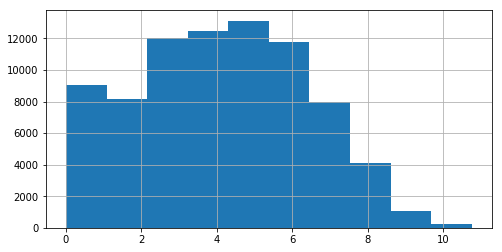

In [80]:
(df_train['sig5'] + 1).apply(np.log).hist()

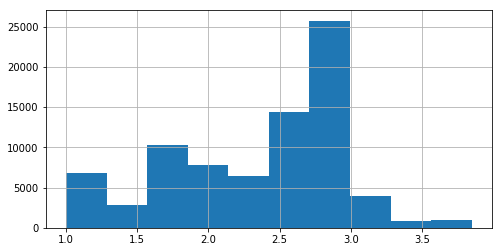

In [81]:
# (df_train['num_queries'] + 1).apply(np.log).hist()
df_train['num_queries'].hist()

In [107]:
#include all features
predictors_idx = [3,5,10,11,13,14,15,16,17,18,19,20]
df_train_predictors = df_train.iloc[:, predictors_idx]
train_predictors = df_train.iloc[:, predictors_idx].as_matrix()
train_response = df_train['relevance'].as_matrix()

In [176]:
for i, v in enumerate(df_train_predictors.columns):
    print i, v
print '\nnumber of total predictors: %d'%len(df_train_predictors.columns)

0 is_homepage
1 sig2
2 sig7
3 sig8
4 query_num
5 query_length_tr
6 sig1_tr
7 sig3_tr
8 sig4_tr
9 sig5_tr
10 sig6_tr
11 num_queries

number of total predictors: 12


In [109]:
#feature selection using variance
# sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
# print sel.fit_transform(train_predictors)
# predictors_idx = [3,13,14,15,16,17]
# df_train_predictors = df_train.iloc[:, predictors_idx]
# train_predictors = df_train.iloc[:, predictors_idx].as_matrix()
# train_response = df_train['relevance'].as_matrix()

In [110]:
scores, pvalues = chi2(train_predictors, train_response)
print pvalues

[  3.55139440e-048   1.01367351e-141   2.06290623e-030   6.19746296e-003
   2.16935252e-016   2.95175930e-001   1.04898970e-040   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   8.36721082e-009]


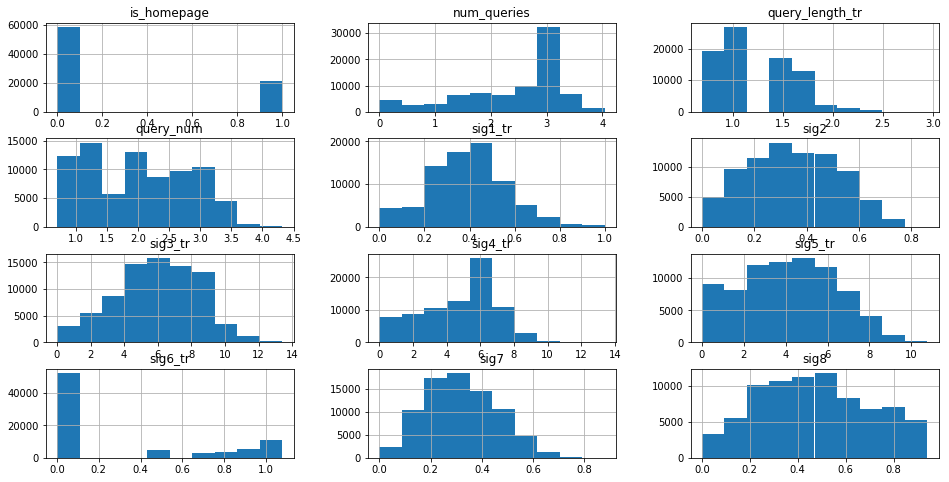

In [179]:
plt.rcParams['figure.figsize'] = (16, 8)
_ = df_train_predictors.hist()
plt.rcParams['figure.figsize'] = (8, 4)

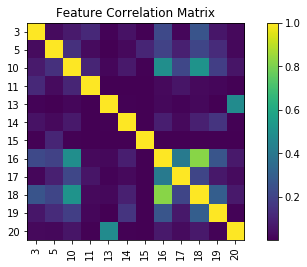

In [112]:
#check correlation between training variables
b = np.corrcoef(train_predictors.T)
fig, ax = plt.subplots()
im = ax.imshow(np.square(b),interpolation='nearest')
fig.colorbar(im)
ax.set_yticks(range(len(predictors_idx)))
ax.set_yticklabels(predictors_idx, rotation='horizontal')
ax.set_xticks(range(len(predictors_idx)))
ax.set_xticklabels(predictors_idx, rotation='vertical')
ax.set_title('Feature Correlation Matrix')
pass

Scale (Normalize and Standardize) all the predictors

In [113]:
tmp = (train_predictors-train_predictors.min(axis=0))
train_predictors_norm = tmp / tmp.max(axis=0)

In [114]:
train_predictors_norm = scale(train_predictors_norm)

## Random Forest

In [180]:
tmp = (train_predictors-train_predictors.min(axis=0))
train_predictors_norm = tmp / tmp.max(axis=0)
train_predictors_norm = scale(train_predictors_norm)
percent_misclassified=0
for train_index, test_index in kf.split(train_predictors_norm):
    x_train, x_test = train_predictors_norm[train_index], train_predictors_norm[test_index]
    y_train, y_test = train_response[train_index], train_response[test_index]
    clf = RandomForestClassifier(n_jobs=-1, max_features=1, n_estimators=500)
    y_pred = clf.fit(x_train, y_train).predict(x_test)
    percent_misclassified+=100*(y_test != y_pred).sum()/float(x_test.shape[0])
#     print("mislabeled out of %d obs : %0.2f"% (x_test.shape[0], 100*(y_test != y_pred).sum()/float(x_test.shape[0])))
print("avg misclassification: %0.2f"%float(percent_misclassified/num_splits))

avg misclassification: 33.31


## Naïve Bayes

Features 13 and 15 look correlated; Removing either do not improve cross validation error significantly

In [274]:
Ntrain,Ptrain = map(float, train_predictors.shape)

In [275]:
from sklearn import datasets
iris = datasets.load_iris()
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(iris.data, iris.target).predict(iris.data)
print("Number of mislabeled points out of a total %d points : %d"
    % (iris.data.shape[0],(iris.target != y_pred).sum()))

Number of mislabeled points out of a total 150 points : 6


In [276]:
gnb.score(iris.data, iris.target)

0.95999999999999996

**10-Fold Cross Validation**

In [181]:
percent_misclassified = 0
for train_index, test_index in kf.split(train_predictors_norm):
    x_train, x_test = train_predictors_norm[train_index], train_predictors_norm[test_index]
    y_train, y_test = train_response[train_index], train_response[test_index]
    #     print float(np.count_nonzero(y_test))/len(y_test)
    gnb = BernoulliNB()
    y_pred = gnb.fit(x_train, y_train).predict(x_test)
    percent_misclassified+=100*(y_test != y_pred).sum()/float(x_test.shape[0])
print("avg misclassification: %0.2f"%float(percent_misclassified/num_splits))

avg misclassification: 38.36


## **KNN Classifier**

In [182]:
percent_misclassified = 0
predictors_idx = [3,5,10,11,13,14,15,16,17,18,19,20]
df_train_predictors = df_train.iloc[:, predictors_idx]
train_predictors = df_train.iloc[:, predictors_idx].as_matrix()
train_response = df_train['relevance'].as_matrix()
tmp = (train_predictors-train_predictors.min(axis=0))
train_predictors_norm = tmp / tmp.max(axis=0)
train_predictors_norm = scale(train_predictors_norm)

for train_index, test_index in kf.split(train_predictors_norm):
    x_train, x_test = train_predictors_norm[train_index], train_predictors_norm[test_index]
    y_train, y_test = train_response[train_index], train_response[test_index]
#     print float(np.count_nonzero(y_test))/len(y_test)
    neigh = KNeighborsClassifier(n_neighbors=150, n_jobs=-1)
    y_pred = neigh.fit(x_train, y_train).predict(x_test)
    percent_misclassified+=100*(y_test != y_pred).sum()/float(x_test.shape[0])
print("avg misclassification: %0.2f"%float(percent_misclassified/num_splits))

avg misclassification: 33.50


# Support Vector Machine

In [172]:
percent_misclassified = 0
for train_index, test_index in kf.split(train_predictors_norm):
    x_train, x_test = train_predictors_norm[train_index], train_predictors_norm[test_index]
    y_train, y_test = train_response[train_index], train_response[test_index]
    clf = svm.SVC(C=2)
    y_pred = clf.fit(x_train, y_train).predict(x_test)
    percent_misclassified+=100*(y_test != y_pred).sum()/float(x_test.shape[0])
print("avg misclassification: %0.2f"%float(percent_misclassified/num_splits))

avg misclassification: 33.21


## Logistic Regression

In [170]:
percent_misclassified = 0
predictors_idx = [3,5,10,11,13,14,15,16,17,18,19,20]
df_train_predictors = df_train.iloc[:, predictors_idx]
train_predictors = df_train.iloc[:, predictors_idx].as_matrix()
train_response = df_train['relevance'].as_matrix()
tmp = (train_predictors-train_predictors.min(axis=0))
train_predictors_norm = tmp / tmp.max(axis=0)
train_predictors_norm = scale(train_predictors_norm)

for train_index, test_index in kf.split(train_predictors_norm):
    x_train, x_test = train_predictors_norm[train_index], train_predictors_norm[test_index]
    y_train, y_test = train_response[train_index], train_response[test_index]
    clf = linear_model.LogisticRegression()
    y_pred = clf.fit(x_train, y_train).predict(x_test)
    percent_misclassified+=100*(y_test != y_pred).sum()/float(x_test.shape[0])
print("avg misclassification: %0.2f"%float(percent_misclassified/num_splits))

avg misclassification: 34.05


## Decision Tree

## AdaBoosting with Decision Tree

In [165]:
percent_misclassified = 0
predictors_idx = [3,5,10,11,13,14,15,16,17,18,19,20]
df_train_predictors = df_train.iloc[:, predictors_idx]
train_predictors = df_train.iloc[:, predictors_idx].as_matrix()
train_response = df_train['relevance'].as_matrix()
tmp = (train_predictors-train_predictors.min(axis=0))
train_predictors_norm = tmp / tmp.max(axis=0)
train_predictors_norm = scale(train_predictors_norm)

for train_index, test_index in kf.split(train_predictors_norm):
    x_train, x_test = train_predictors_norm[train_index], train_predictors_norm[test_index]
    y_train, y_test = train_response[train_index], train_response[test_index]
    clf = AdaBoostClassifier(n_estimators=100)
    y_pred = clf.fit(x_train, y_train).predict(x_test)
    percent_misclassified+=100*(y_test != y_pred).sum()/float(x_test.shape[0])
print("avg misclassification: %0.2f"%float(percent_misclassified/num_splits))

avg misclassification: 33.76
